In [1]:
import sys
import os
import cv2
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import torch
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import skimage

In [2]:
sys.path.append('/home/edshkim98/shkim/pytorch-multi-class-focal-loss')
from focal_loss import *
# import EarlyStopping
from earlystopping import *

In [3]:
#SUMMARY 22/10/2020
#Libraries used: Pytorch, OpenCV, PIL, Matplotlib etc.
#Two cases: 1. Segmentation of seeps(classes=8) 2. Segmentation and classification of each class of seep(classes=2)
#Hugly Unbalanced dataset
#Tried to use an edge enhancement technique such as Laplacian kernel, but did not work out well.
#Main challenge was dealing with the unbalanced data

In [4]:
path = r'/home/edshkim98/shkim/data/'
torch.manual_seed(42)

In [5]:
def plot_img(img, mask):
    fig, ax = plt.subplots(1,2, figsize=(12,8))
    
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[1].imshow(mask)
    ax[1].set_title("Mask")

    plt.show()

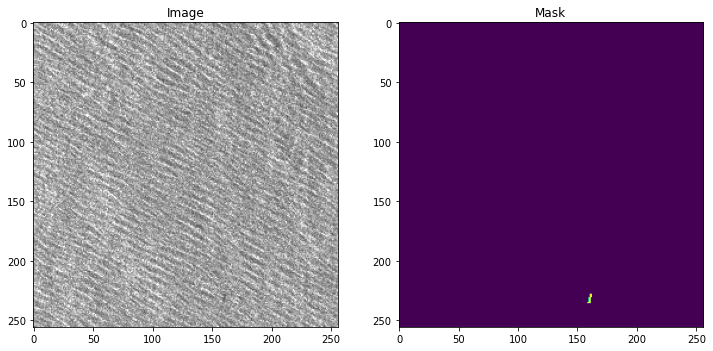

In [6]:
img_path = path+"seep_detection/train_images_256/"
mask_path = path+"seep_detection/train_masks_256/"

images = []
masks = []

for filename in os.listdir(img_path):
    images.append(cv2.cvtColor(cv2.imread(img_path + filename), cv2.COLOR_BGR2RGB))
    masks.append(plt.imread(mask_path + filename))

images = np.array(images)
masks = np.array(masks)

plot_img(images[1], masks[1])

In [7]:
images.shape[1]

256

In [8]:
dc = {}
for i in range(8):
    dc[i] = 0
dc

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}

In [9]:
lst = []
for i in os.listdir(path+"seep_detection/train_masks_256/"):
    img = Image.open(path+"seep_detection/train_masks_256/"+i)
    img = np.asarray(img)
    for j in np.unique(img):
        dc[j]+=1
    lst.append(np.unique(img))

In [10]:
dc

{0: 790, 1: 478, 2: 161, 3: 76, 4: 66, 5: 125, 6: 200, 7: 51}

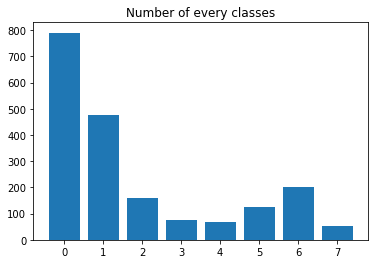

In [11]:
plt.bar(range(len(dc)), list(dc.values()), align='center')
plt.xticks(range(len(dc)), list(dc.keys()))
plt.title("Number of every classes")
plt.show()

In [51]:
from __future__ import print_function, division
from skimage import io, transform
from torchvision import transforms, utils
from torch.utils.data.dataset import random_split
import torchvision.transforms.functional as TF
import utils

    
train_transforms = transforms.Compose([
    transforms.ToTensor()
    #transforms.Normalize()
                    ])
def oversample(img, mask):
    angle = random.randint(0,181)
    img = TF.rotate(img,angle)
    mask = TF.rotate(mask,angle)
    
    # Random horizontal flipping
    if random.random() > 0.5:
        img = TF.hflip(img)
        mask = TF.hflip(mask)

    # Random vertical flipping
    if random.random() > 0.5:
        img = TF.vflip(img)
        mask = TF.vflip(mask)

    '''    
    if random.random() > 0.5:
        mean=0.
        std=1.
        img = img + torch.randn(256,256,3) * std + mean
        #print(img.shape)
    '''  
    return img,mask
class CustomDataset(Dataset):
    def __init__(self,path,val_files,transform = train_transforms, valid = False):
        self.path =path
        self.valid = valid
        self.files = []
        self.transforms = transform
        
        new_dir = self.path+'seep_detection/train_images_256/'
        new_dir2 = self.path+"seep_detection/train_masks_256/"
        
        self.total = os.listdir(new_dir)
        
        if self.valid: #if validation
            self.val_files = val_files
            for i in self.val_files:
                sample = {}
                img = cv2.imread(new_dir+str(i))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                #kernel = np.array([[-1,-1,-1], 
                #   [-1, 9,-1],
                #   [-1,-1,-1]])
                #img = cv2.filter2D(img, -1, kernel) # applying the sharpening kernel to the input image & displaying it.
                img = Image.fromarray(img)

                mask = cv2.imread(new_dir2+str(i))
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
                '''
                for i in range((mask.shape[0])): #changing to binary classfication problem
                    for j in range((mask.shape[1])):
                        if mask[i][j] > 0:
                            mask[i][j] = 1
                        else:
                            mask[i][j] = 0          
                '''
                mask = Image.fromarray(mask)

                sample['image'] = img
                sample['mask'] = mask
                self.files.append(sample)

        else:
            self.train = [i for i in self.total if i not in val_files]
            for i in self.train:
                sample = {}
                img = cv2.imread(new_dir+str(i))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                #kernel = np.array([[-1,-1,-1], 
                #   [-1, 9,-1],
                #   [-1,-1,-1]])
                #img = cv2.filter2D(img, -1, kernel) # applying the sharpening kernel to the input image & displaying it.
                img = Image.fromarray(img)
                
                mask = cv2.imread(new_dir2+str(i))
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
                '''
                classes = np.unique(mask)
                mask_1 = Image.fromarray(mask)
                minor = [2,3,4,5,6,7]
                
                classes_1 = list(classes)
                for i in minor:
                    if classes_1 == [0,i]:
                        if i in [3,7]:
                            for _ in range(13):
                                img2, mask2 = oversample(img, mask_1)
                                sample['image'] = img2
                                sample['mask'] = mask
                                self.files.append(sample)
                        elif i == 2:
                            for _ in range(5):
                                img2, mask2 = oversample(img, mask_1)
                                sample['image'] = img2
                                sample['mask'] = mask
                                self.files.append(sample)
                        elif i == 6:
                            for _ in range(4):
                                img2, mask2 = oversample(img, mask_1)
                                sample['image'] = img2
                                sample['mask'] = mask
                                self.files.append(sample)
                        elif i == 4:
                            for _ in range(7):
                                img2, mask2 = oversample(img, mask_1)
                                sample['image'] = img2
                                sample['mask'] = mask
                                self.files.append(sample)
                        else:
                            for _ in range(3):
                                img2,mask2 = oversample(img, mask_1)
                                sample['image'] = img2
                                sample['mask'] = mask
                                self.files.append(sample)
                '''
                '''
                for i in range((mask.shape[0])): #changing to binary classfication problem
                    for j in range((mask.shape[1])):
                        if mask[i][j] > 0:
                            mask[i][j] = 1
                        else:
                            mask[i][j] = 0
                '''
                mask = Image.fromarray(mask)
        
                sample['image'] = img
                sample['mask'] = mask
                self.files.append(sample)
                
              
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self,idx):
        x = self.files[idx]['image']
        y = self.files[idx]['mask']
        img = x
        mask = y
        if self.valid:
            pass
        else:
            # Random rotating
            if random.random() > 0.5:
                angle = random.randint(0,91)
                img = TF.rotate(img,angle)
                mask = TF.rotate(mask,angle)

            # Random horizontal flipping
            if random.random() > 0.5:
                img = TF.hflip(img)
                mask = TF.hflip(mask)

            # Random vertical flipping
            if random.random() > 0.5:
                img = TF.vflip(img)
                mask = TF.vflip(mask)
        
        if self.transforms:
            img = self.transforms(img)
        mask = np.asarray(mask)
        return {"image": img, "mask": mask.astype(int)}

In [52]:
batch_size = 16
x = os.listdir(path+'seep_detection/train_images_256/')

total = len(x)
train_num = int(total * 0.85)
val_num = int(total * 0.15)
if (train_num+val_num) < total:
    train_num += 1
print("total: ",total)
print("val+train: ",val_num+train_num)
print("train: ", train_num)
print("val: ", val_num)

def train_val_split(total, val_num):
    val = np.random.choice(len(total), val_num,replace=False)
    val_files = list(np.asarray(total)[val])
    train_files = [i for i in total if i not in val_files]
    
    return val,val_files,train_files

val,val_files,train_files = train_val_split(x, val_num)

train_dataset = CustomDataset(path,val_files, transform =train_transforms,valid = False)
val_dataset = CustomDataset(path, val_files,transform=train_transforms, valid=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last = True)

print('######### Dataset class created #########')
print('Number of images: ', total)
print('train size in no of batch: ',len(train_loader))
print("test size in no of batch: ",len(val_loader))
print('train size: ',len(train_loader)*batch_size)
print("test size: ",len(val_loader)*batch_size)

total:  790
val+train:  790
train:  672
val:  118
######### Dataset class created #########
Number of images:  790
train size in no of batch:  42
test size in no of batch:  7
train size:  672
test size:  112


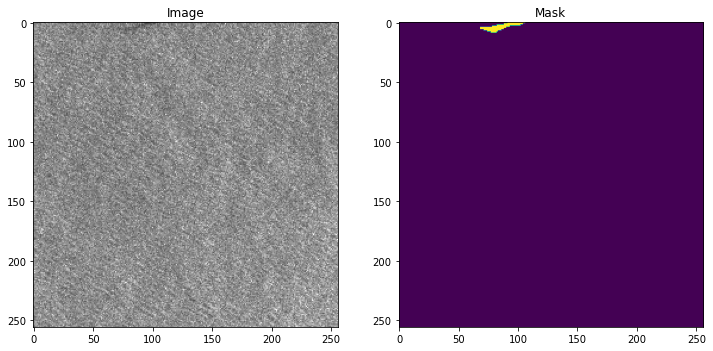

In [14]:
x = next(iter(train_loader))
x['image'][1].shape
plot_img(x['image'][3].permute(1,2,0), x['mask'][3])

In [15]:
z = x['mask'][1]
z = np.array(z)
np.unique(z) 

array([0, 1])

In [16]:
dc2 = {}
for i in range(8):
    dc2[i] = 0
dc2

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}

In [17]:
lst2 = []
for i,data in enumerate(train_loader):
    masks = data['mask']
    masks = np.array(masks)
    for j in range(masks.shape[0]):
        img = np.asarray(masks[j])
        for j in np.unique(img):
            dc2[j]+=1
            lst2.append(np.unique(img))


In [18]:
dc2

{0: 672, 1: 644, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}

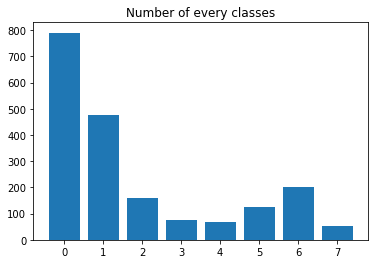

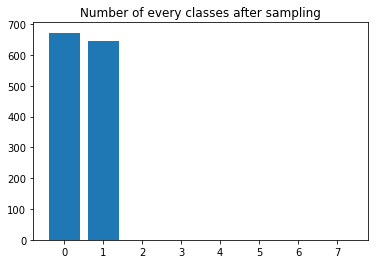

In [19]:
plt.bar(range(len(dc)), list(dc.values()), align='center')
plt.xticks(range(len(dc)), list(dc.keys()))
plt.title("Number of every classes")
plt.show()

plt.bar(range(len(dc2)), list(dc2.values()), align='center')
plt.xticks(range(len(dc2)), list(dc2.keys()))
plt.title("Number of every classes after sampling")
plt.show()

In [20]:
import torch.nn as nn

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self,x):
        return x
    

In [21]:
class deeplabv3(nn.Module):
    def __init__(self,num_classes):
        super(deeplabv3, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet101(pretrained=True)
        self.model.classifier[-1] = nn.Conv2d(256,num_classes,1)
        self.model.aux_classifier = nn.Sequential(
            nn.Conv2d(1024, 256,3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes,1)
        )
        for param in self.model.parameters(): #making all layers fine tuneable
            param.requires_grad = True

    def forward(self, inputs): # inputs.shape = samples x channels x height x width 
        outputs = self.model(inputs)
        return outputs
    

In [22]:
torch.cuda.set_device(0)
torch.cuda.device_count()
torch.cuda.current_device()

0

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [24]:
model = deeplabv3(num_classes=2)
model.to(device)

deeplabv3(
  (model): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (

In [25]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print("total number of parameters: ",pytorch_total_params)

total number of parameters:  60986692


In [26]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), 0.01,weight_decay=1e-4)
lmbda = lambda epoch: 0.95
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
batch_size

16

In [27]:
def dice_loss(true, logits, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

In [28]:
def one_hot(labels, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes)
    return y[labels]

class mIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=8):
        super(mIoULoss, self).__init__()
        self.classes = n_classes

    def forward(self, inputs, target_oneHot):
        # inputs => N x Classes x H x W
        # target_oneHot => N x Classes x H x W

        N = inputs.size()[0]

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)

        # Numerator Product
        inter = inputs * target_oneHot
        ## Sum over all pixels N x C x H x W => N x C
        inter = inter.view(N,self.classes,-1).sum(2)

        #Denominator 
        union= inputs + target_oneHot - (inputs*target_oneHot)
        ## Sum over all pixels N x C x H x W => N x C
        union = union.view(N,self.classes,-1).sum(2)

        loss = inter/union

        ## Return average loss over classes and batch
        return -loss.mean()


In [29]:
def weights_calc(y1, batch_size):
    cnt = {'0':0,'1':0, '2':0, '3':0,'4':0,'5':0,'6':0,'7':0}
    y1 = y1.cpu().detach().numpy()
    for batch in range(batch_size):
        for i in range(y1[batch].shape[0]):
            for j in range(y1[batch].shape[1]):
                if y1[batch][i][j] == 0:
                    cnt['0'] +=1
                elif y1[batch][i][j] > 0:
                    cnt['1'] +=1
                '''
                elif y1[batch][i][j] == 1:
                    cnt[str(np.array(y1[batch][i][j]))] +=1
                elif y1[batch][i][j] == 2:
                    cnt[str(np.array(y1[batch][i][j]))] +=1
                elif y1[batch][i][j] == 3:
                    cnt[str(np.array(y1[batch][i][j]))] +=1
                elif y1[batch][i][j] == 4:
                    cnt[str(np.array(y1[batch][i][j]))] +=1
                elif y1[batch][i][j] == 5:
                    cnt[str(np.array(y1[batch][i][j]))] +=1
                elif y1[batch][i][j] == 6:
                    cnt[str(np.array(y1[batch][i][j]))] +=1
                elif y1[batch][i][j] == 7:
                    cnt[str(np.array(y1[batch][i][j]))] +=1
                '''
    for i in range(2, len(cnt.keys())):
        cnt[str(i)] = cnt['1']
        
    values = list(cnt.values())
    values = [1/i for i in values]
    return values

def normalize(weights):
    weights = np.array(weights)
    maximum = weights.max()
    minimum = weights.min()
    weights = [(i-minimum)/(maximum-minimum) for i in weights]
    return weights


In [30]:
def customized_loss(pred, label):
    #weights = weights_calc(label,16)
    #weights = [0.05, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
    weights = [0.05, 1.0]
    class_weights = torch.FloatTensor(weights).cuda()
    
    alpha = class_weights
    gamma = 2
    focal_loss = FocalLoss(alpha, gamma)
    focal_ls = focal_loss(pred, label)
    '''
    focal_loss = torch.hub.load(
    repo_or_dir='adeelh/pytorch-multi-class-focal-loss',
    model='FocalLoss',
    alpha=torch.tensor(class_weights),
    gamma=2,
    reduction='mean',
    force_reload=False)
    focal_loss = focal_loss(pred, label)
    '''
    
    #criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    #celoss = criterion(pred, label)
    label_en = one_hot(label,2)#
    label_en = label_en.permute(0,3,1,2)
    label_en = label_en.to(device)
    iou = mIoULoss()(pred,label_en)
    #iou_loss = mIOU(label, pred)
    #iou_loss = -np.log(iou_loss)
    dice = dice_loss(label,pred)

    
    return 0.25*focal_ls+1.5*iou+1.5*dice

In [31]:
def mIOU(label, pred, num_classes=2):
    pred = F.softmax(pred, dim=1)              
    pred = torch.argmax(pred, dim=1).squeeze(1)
    iou_list = list()
    present_iou_list = list()

    pred = pred.view(-1)
    label = label.view(-1)
    # Note: Following for loop goes from 0 to (num_classes-1)
    # and ignore_index is num_classes, thus ignore_index is
    # not considered in computation of IoU.
    for sem_class in range(num_classes):
        pred_inds = (pred == sem_class)
        target_inds = (label == sem_class)
        if target_inds.long().sum().item() == 0:
            iou_now = float('nan')
        else: 
            intersection_now = (pred_inds[target_inds]).long().sum().item()
            union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)
        iou_list.append(iou_now)
    return np.mean(present_iou_list)

In [32]:
def train(model,train_loader,valid_loader,epochs=100,alpha = 0.001, save=True):
    # initialize the early_stopping object
    patience = 10
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    loss_trend = []
    iou_trend = []
    best = 0
    for epoch in range(epochs):
        e = epoch
        model.train()
        scheduler.step()

        for i, data in enumerate(train_loader):
            total = 0
            correct = 0
            inputs, labels = data['image'].type(torch.FloatTensor).to(device), data['mask'].to(device)
            output = model(inputs)
            _,pred = torch.max(output['out'].data,1)
            optimizer.zero_grad()
            
            loss = customized_loss(output['out'],labels)
            loss.backward()
            optimizer.step()
            total += labels.size(1) * labels.size(2) * 16
            correct += (pred == labels).sum().item()
            iou = mIOU(labels,output['out'])
                        
            if i%5 == 0:
                acc = 100. * correct/total
                print("Epoch: {}, Loss:{:.6f}, Accuracy:{:.6f}, mIOU:{}".format(epoch,loss.item(),acc,iou))#,np.mean(ious)))
            
        model.eval()
        total = 0
        correct =0
        loss =[]
        ious = []
        with torch.no_grad():  
            for i, data in enumerate(val_loader):
                inputs, labels = data['image'].type(torch.FloatTensor).to(device), data['mask'].to(device)
                output= model(inputs)                
                
                ls = customized_loss(output['out'],labels)
                loss.append(ls.item())
                _,pred = torch.max(output['out'].data,1) 

                total += labels.size(1) * labels.size(2)*16
                correct += (pred == labels).sum().item()
                iou = mIOU(labels,output['out'])
                ious.append(iou)


                
            acc = 100. * correct / total
            loss_final = np.mean(loss)
            loss_trend.append(loss_final)
            iou = np.mean(ious)
            iou_trend.append(iou)
            if iou > best:
                best = iou
            print("The validation accuracy: {:.6f} and the validation loss: {:.6f}, mIOU:{}".format(acc,loss_final,iou))
        
        # early_stopping needs the iou value to check if it has increased, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(1-iou, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            print("Best model iou: {}".format(best))
            break

    return loss_trend, iou_trend

In [33]:
loss, iou = train(model,train_loader, val_loader, save=True)

/home/edshkim98/anaconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:118: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-28-9c28e13b6eb4>:29: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
  inter = inputs * target_oneHot


Epoch: 0, Loss:0.575015, Accuracy:63.870716, mIOU:0.3270326509450969
Epoch: 0, Loss:0.032630, Accuracy:98.515511, mIOU:0.49257755279541016
Epoch: 0, Loss:0.062440, Accuracy:97.865582, mIOU:0.48932790756225586
Epoch: 0, Loss:0.059246, Accuracy:97.848129, mIOU:0.4892406463623047
Epoch: 0, Loss:0.034647, Accuracy:98.710442, mIOU:0.49355220794677734
Epoch: 0, Loss:0.060152, Accuracy:98.420906, mIOU:0.49210453033447266
Epoch: 0, Loss:-0.045934, Accuracy:98.210812, mIOU:0.49105405807495117
Epoch: 0, Loss:0.010954, Accuracy:99.068165, mIOU:0.49534082412719727
Epoch: 0, Loss:-0.123749, Accuracy:98.392868, mIOU:0.49196434020996094
The validation accuracy: 98.233659 and the validation loss: nan, mIOU:0.49116829463413786
Validation loss decreased (inf --> 0.508832).  Saving model ...
Epoch: 1, Loss:-0.101266, Accuracy:97.355366, mIOU:0.48677682876586914
Epoch: 1, Loss:-0.139559, Accuracy:97.867298, mIOU:0.4893364906311035
Epoch: 1, Loss:-0.186448, Accuracy:98.299313, mIOU:0.49149656295776367
Epoc

Epoch: 10, Loss:-0.279830, Accuracy:98.992920, mIOU:0.6240822315821626
Epoch: 10, Loss:-0.379753, Accuracy:97.372913, mIOU:0.6210425657721245
The validation accuracy: 98.389121 and the validation loss: nan, mIOU:0.6817408916592145
Validation loss decreased (0.335757 --> 0.318259).  Saving model ...
Epoch: 11, Loss:-0.428128, Accuracy:98.264790, mIOU:0.6416372480724123
Epoch: 11, Loss:-0.387478, Accuracy:98.607826, mIOU:0.6323076885208928
Epoch: 11, Loss:-0.420832, Accuracy:98.840809, mIOU:0.6615208940752898
Epoch: 11, Loss:-0.432529, Accuracy:98.194599, mIOU:0.6486016880120766
Epoch: 11, Loss:-0.487513, Accuracy:98.718357, mIOU:0.6977038316438836
Epoch: 11, Loss:-0.452500, Accuracy:97.625637, mIOU:0.6510251630870463
Epoch: 11, Loss:-0.375487, Accuracy:97.624207, mIOU:0.6266435828872718
Epoch: 11, Loss:-0.544980, Accuracy:98.289204, mIOU:0.7014575437663202
Epoch: 11, Loss:-0.429799, Accuracy:98.102379, mIOU:0.6462212828335704
The validation accuracy: 98.397487 and the validation loss: n

Epoch: 21, Loss:-0.432623, Accuracy:98.305702, mIOU:0.6368160243513081
Epoch: 21, Loss:-0.437447, Accuracy:97.950745, mIOU:0.6698150310299815
Epoch: 21, Loss:-0.462906, Accuracy:98.298359, mIOU:0.6700655788665602
Epoch: 21, Loss:-0.561206, Accuracy:98.392487, mIOU:0.7099788589164143
Epoch: 21, Loss:-0.443178, Accuracy:98.373604, mIOU:0.6494256252502695
Epoch: 21, Loss:-0.573144, Accuracy:98.965454, mIOU:0.7337450380023101
Epoch: 21, Loss:-0.505049, Accuracy:98.534489, mIOU:0.6810547224964638
The validation accuracy: 98.573780 and the validation loss: -0.527728, mIOU:0.6963241292710494
EarlyStopping counter: 2 out of 10
Epoch: 22, Loss:-0.498967, Accuracy:98.406219, mIOU:0.6956307677864633
Epoch: 22, Loss:-0.653126, Accuracy:99.095345, mIOU:0.7564895033984071
Epoch: 22, Loss:-0.538223, Accuracy:98.219967, mIOU:0.7010823009608353
Epoch: 22, Loss:-0.441755, Accuracy:98.222446, mIOU:0.6753926009428929
Epoch: 22, Loss:-0.592337, Accuracy:98.900795, mIOU:0.7307808970285197
Epoch: 22, Loss:-0

The validation accuracy: 98.401342 and the validation loss: -0.554178, mIOU:0.7029199097565609
EarlyStopping counter: 4 out of 10
Epoch: 32, Loss:-0.310293, Accuracy:98.735332, mIOU:0.6185367778630848
Epoch: 32, Loss:-0.560398, Accuracy:99.373341, mIOU:0.7240588316910705
Epoch: 32, Loss:-0.507155, Accuracy:99.055672, mIOU:0.6911339840383554
Epoch: 32, Loss:-0.488468, Accuracy:98.690319, mIOU:0.6820497995435514
Epoch: 32, Loss:-0.447789, Accuracy:99.022007, mIOU:0.6590113524878657
Epoch: 32, Loss:-0.572512, Accuracy:98.021793, mIOU:0.7050355375805869
Epoch: 32, Loss:-0.391891, Accuracy:98.679733, mIOU:0.6420088631789447
Epoch: 32, Loss:-0.392134, Accuracy:98.602772, mIOU:0.6326816852861223
Epoch: 32, Loss:-0.411237, Accuracy:98.574257, mIOU:0.6260710079779824
The validation accuracy: 98.503072 and the validation loss: -0.565581, mIOU:0.7088384121104622
Validation loss decreased (0.291913 --> 0.291162).  Saving model ...
Epoch: 33, Loss:-0.476742, Accuracy:98.938084, mIOU:0.6820686702813

Epoch: 42, Loss:-0.606560, Accuracy:98.697948, mIOU:0.7481164734942958
Epoch: 42, Loss:-0.583751, Accuracy:98.179913, mIOU:0.7239487823001619
Epoch: 42, Loss:-0.502453, Accuracy:98.887062, mIOU:0.6745514989669222
Epoch: 42, Loss:-0.470326, Accuracy:99.241257, mIOU:0.6784073129147359
Epoch: 42, Loss:-0.560139, Accuracy:98.267269, mIOU:0.7094586721030136
The validation accuracy: 98.521859 and the validation loss: -0.580617, mIOU:0.7147888397820683
EarlyStopping counter: 1 out of 10
Epoch: 43, Loss:-0.504239, Accuracy:98.453522, mIOU:0.6957204091398955
Epoch: 43, Loss:-0.435591, Accuracy:98.196507, mIOU:0.6547070366115624
Epoch: 43, Loss:-0.456349, Accuracy:97.836590, mIOU:0.6462869130618007
Epoch: 43, Loss:-0.610756, Accuracy:97.670650, mIOU:0.7296612278655936
Epoch: 43, Loss:-0.471575, Accuracy:98.540878, mIOU:0.6785369612038109
Epoch: 43, Loss:-0.582263, Accuracy:98.698425, mIOU:0.7053265478578535
Epoch: 43, Loss:-0.502964, Accuracy:98.562908, mIOU:0.7060141664026148
Epoch: 43, Loss:-0

Epoch: 53, Loss:-0.637657, Accuracy:98.418617, mIOU:0.7470054782045861
Epoch: 53, Loss:-0.633845, Accuracy:99.115562, mIOU:0.7456460992072813
Epoch: 53, Loss:-0.557502, Accuracy:97.815990, mIOU:0.7113177348119859
Epoch: 53, Loss:-0.641202, Accuracy:99.074841, mIOU:0.759326217685222
Epoch: 53, Loss:-0.558240, Accuracy:98.871994, mIOU:0.7091758967662349
Epoch: 53, Loss:-0.554272, Accuracy:98.389149, mIOU:0.6968358887191256
Epoch: 53, Loss:-0.496491, Accuracy:98.906040, mIOU:0.6842650946665803
Epoch: 53, Loss:-0.568259, Accuracy:98.783588, mIOU:0.7079139731069563
Epoch: 53, Loss:-0.473714, Accuracy:98.678112, mIOU:0.6789588906080468
The validation accuracy: 98.613126 and the validation loss: -0.596227, mIOU:0.7205694380405584
EarlyStopping counter: 5 out of 10
Epoch: 54, Loss:-0.642754, Accuracy:98.506165, mIOU:0.7333280943456542
Epoch: 54, Loss:-0.540711, Accuracy:97.726631, mIOU:0.7036384148563574
Epoch: 54, Loss:-0.627255, Accuracy:98.866177, mIOU:0.7210169513501149
Epoch: 54, Loss:-0.

Epoch: 63, Loss:-0.519860, Accuracy:98.332310, mIOU:0.691001041971244
Epoch: 63, Loss:-0.615894, Accuracy:97.709274, mIOU:0.756439412595219
The validation accuracy: 98.609747 and the validation loss: -0.602377, mIOU:0.7238122996014026
EarlyStopping counter: 3 out of 10
Epoch: 64, Loss:-0.461940, Accuracy:98.617172, mIOU:0.6573905776602238
Epoch: 64, Loss:-0.448326, Accuracy:98.460197, mIOU:0.6474976873058425
Epoch: 64, Loss:-0.542039, Accuracy:98.875713, mIOU:0.7071309940794959
Epoch: 64, Loss:-0.592737, Accuracy:98.211193, mIOU:0.7240775139529364
Epoch: 64, Loss:-0.471950, Accuracy:97.585487, mIOU:0.6568656367015506
Epoch: 64, Loss:-0.559323, Accuracy:98.032665, mIOU:0.7410441274935899
Epoch: 64, Loss:-0.645486, Accuracy:98.843384, mIOU:0.7233124773905911
Epoch: 64, Loss:-0.625316, Accuracy:98.514652, mIOU:0.7323665648158156
Epoch: 64, Loss:-0.504328, Accuracy:98.069954, mIOU:0.6843722628005884
The validation accuracy: 98.556873 and the validation loss: -0.597902, mIOU:0.7195453894213

In [35]:
#Best IoU for seg class = 8: 0.243 0.25focal
#Best IoU for seg class = 2: 0.668 -> 0.724 using focal loss


Text(0.5, 1.0, 'IoU for segmentation of seeps (class=8) w focal loss 0.243')

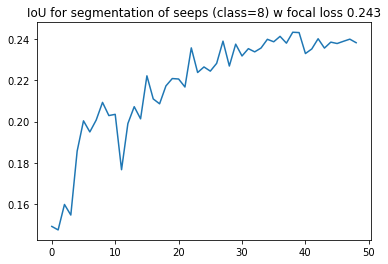

In [35]:
plt.plot(iou)
plt.title("IoU for segmentation of seeps (class=8) w focal loss 0.243")

Text(0.5, 1.0, 'IoU for segmentation of seeps (class=8)')

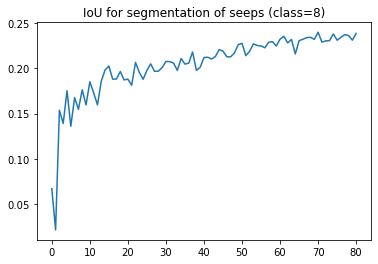

In [28]:
plt.plot(iou)
plt.title("IoU for segmentation of seeps (class=8) ")

Text(0.5, 1.0, 'IoU for segmentation of seeps (class=2)')

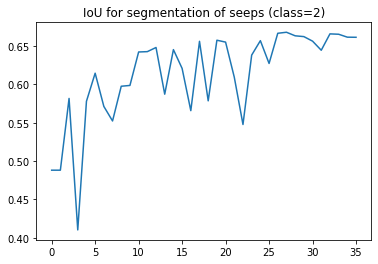

In [32]:
plt.plot(iou)
plt.title("IoU for segmentation of seeps (class=2)")

Text(0.5, 1.0, 'IoU for segmentation of seeps (class=2) w focal loss 0.724')

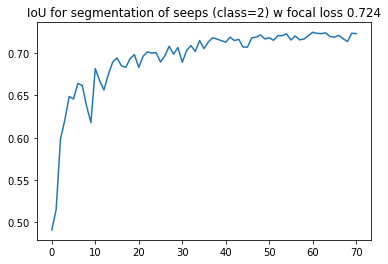

In [34]:
plt.plot(iou)
plt.title("IoU for segmentation of seeps (class=2) w focal loss 0.724")

In [36]:
model = deeplabv3(num_classes=8)
model.to(device)
model.load_state_dict(torch.load("checkpoint_seg8.pt"))
model.eval()

model2 = deeplabv3(num_classes=2)
model2.to(device)
model2.load_state_dict(torch.load("checkpoint.pt"))
model2.eval()

deeplabv3(
  (model): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (

In [44]:

def plot_test_mask(img, true, pred, pred2, iou, iou2):
    fig, ax = plt.subplots(1,4, figsize=(16,8))
        
    ax[0].imshow(img)
    ax[0].set_title("Seep Image")

    ax[1].imshow(true)
    ax[1].set_title("Ground truth")
    
    ax[2].imshow(pred)
    ax[2].set_title("Pred for classes = 8 {:.4f}IoU".format(iou))
    
    ax[3].imshow(pred2)
    ax[3].set_title("Pred for classes = 2 {:.4f}IoU".format(iou2))

    plt.show()

In [53]:
test = next(iter(val_loader))


In [54]:
inputs, labels = test['image'].type(torch.FloatTensor).to(device), test['mask']#.to(device)




Sample 0


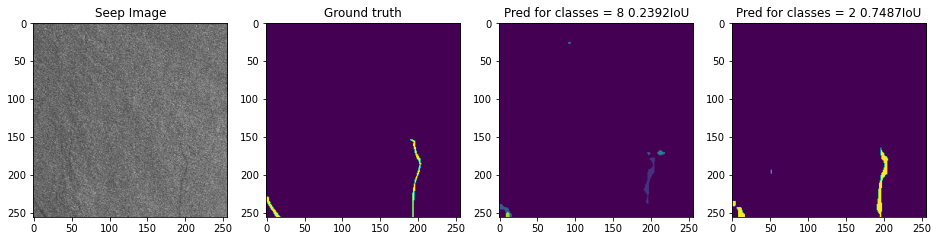




Sample 1


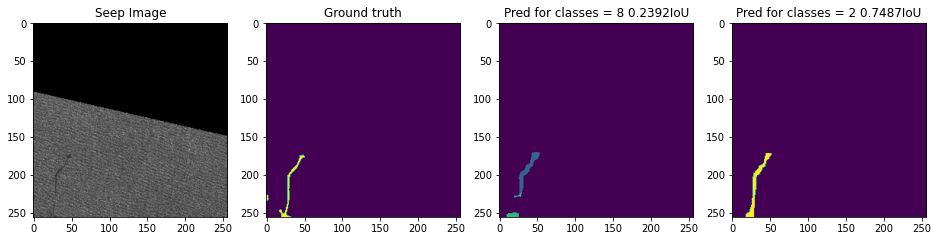




Sample 2


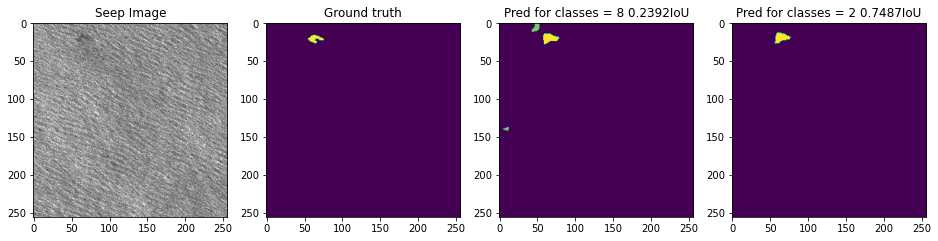




Sample 3


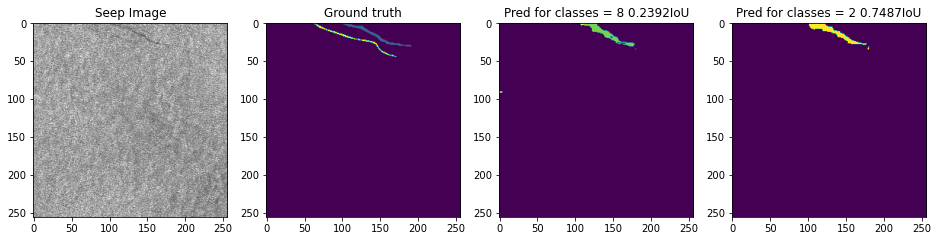




Sample 4


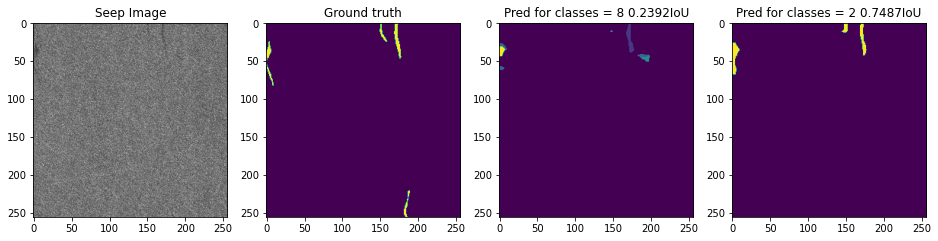




Sample 5


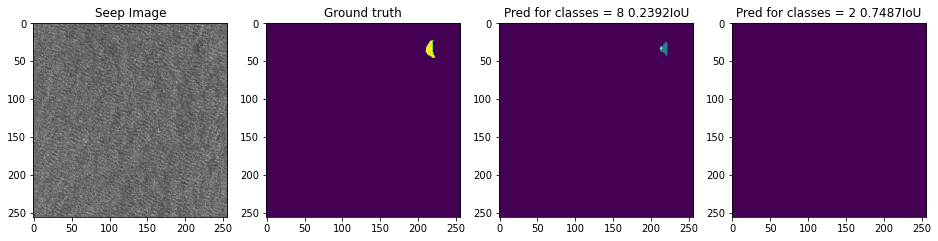




Sample 6


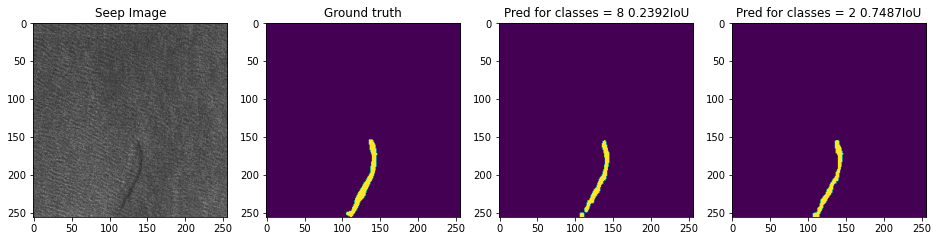




Sample 7


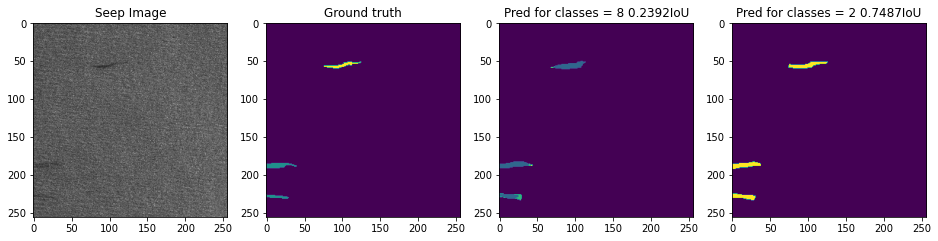




Sample 8


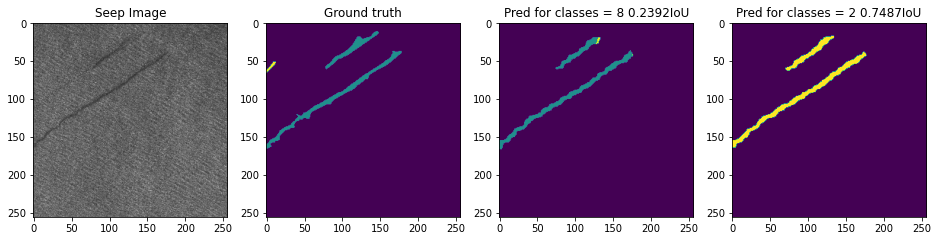




Sample 9


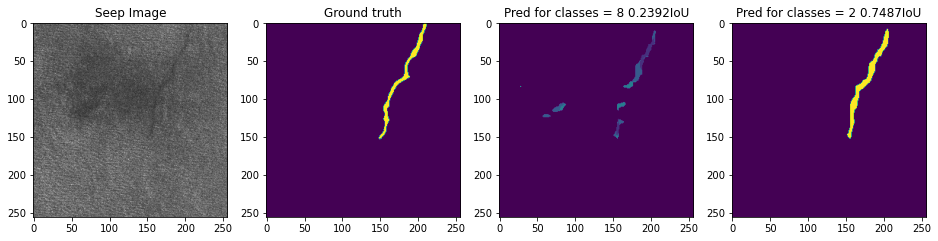




Sample 10


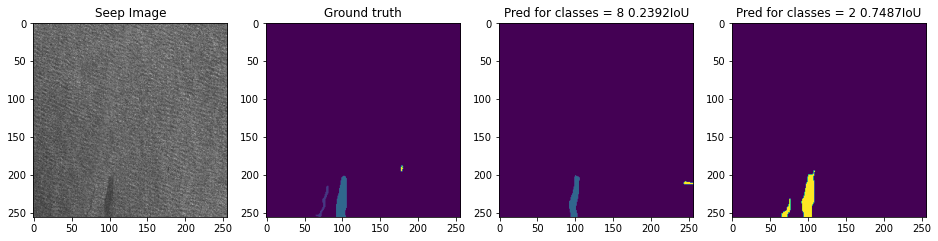




Sample 11


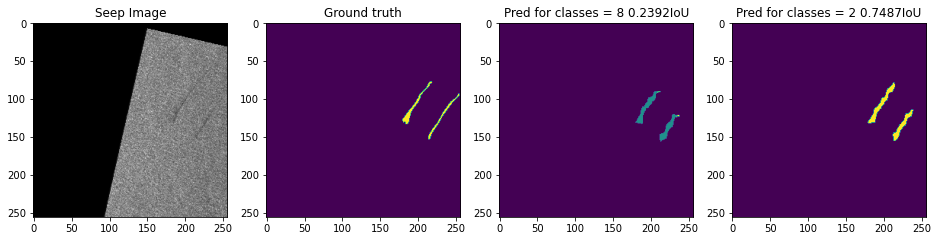




Sample 12


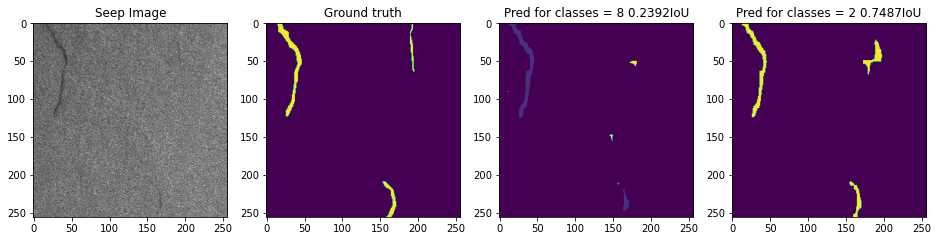




Sample 13


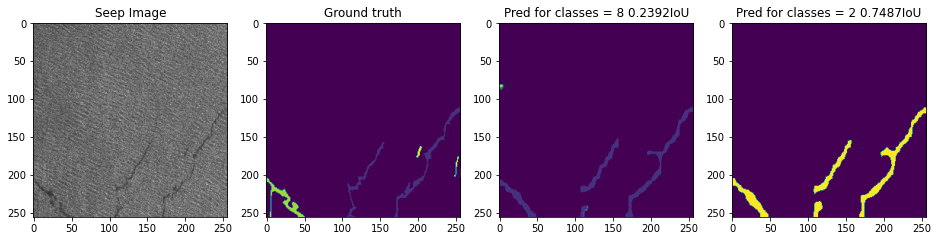




Sample 14


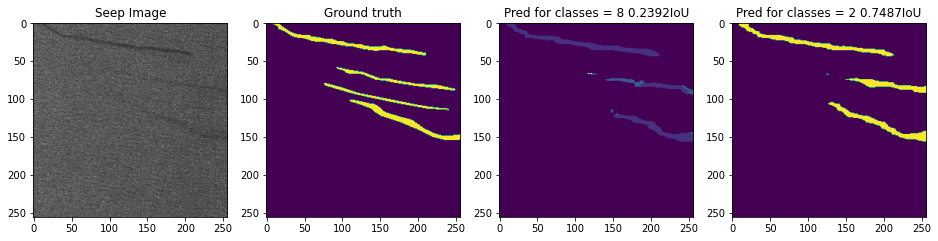




Sample 15


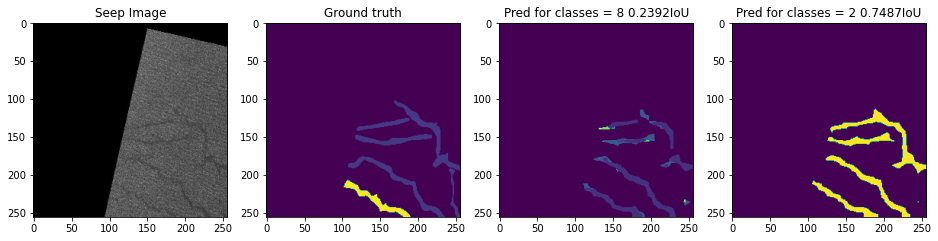

In [55]:
with torch.no_grad():
    output = model(inputs)
    output2 = model2(inputs)
    _,pred = torch.max(output['out'].data,1)
    iou = mIOU(labels,output['out'],8)
    _,pred2 = torch.max(output2['out'].data,1)
    iou2 = mIOU(labels,output2['out'],2)
    for idx in range(batch_size):
        print("\n\n\nSample {}".format(idx))
        plot_test_mask(inputs[idx].permute(1,2,0).cpu().detach().numpy(), labels[idx], pred[idx].cpu().detach().numpy(),
                       pred2[idx].cpu().detach().numpy(),iou=iou,iou2=iou2)

In [ ]:
#End